In [136]:
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import StandardScaler, Normalizer, KBinsDiscretizer, FunctionTransformer, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [137]:
data_cols = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]
target_col = "class"
col_names = ["id", *data_cols, target_col]

file_path = "../data/glass.data"
dataset = pd.read_csv(file_path, names=col_names)

# Exploration

In [138]:
dataset.shape

(214, 11)

In [139]:
dataset.head(10)

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [140]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  class   214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [141]:
dataset.describe()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [142]:
dataset[target_col].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: class, dtype: int64

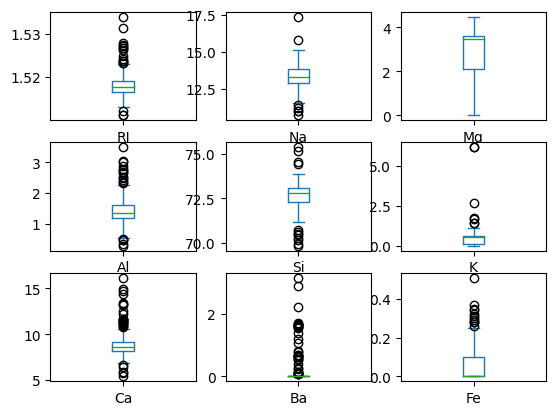

In [143]:
dataset[data_cols].plot(kind="box", subplots=True, layout=(3, 3), sharex=False, sharey=False)
plt.show()

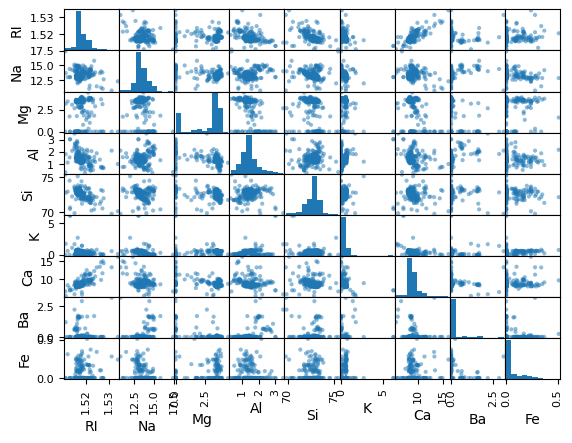

In [144]:
pd.plotting.scatter_matrix(dataset[data_cols])
plt.show()

# Preprocessing

In [145]:
rng = np.random.RandomState(1)

In [146]:
X_full = dataset[data_cols]
Y = dataset[target_col]

In [147]:
missing_ratio = 0.05
X = X_full.mask(rng.random(X_full.shape) < missing_ratio)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      199 non-null    float64
 1   Na      208 non-null    float64
 2   Mg      196 non-null    float64
 3   Al      201 non-null    float64
 4   Si      207 non-null    float64
 5   K       197 non-null    float64
 6   Ca      204 non-null    float64
 7   Ba      204 non-null    float64
 8   Fe      207 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [148]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=rng)

In [149]:
imputers = {
    "KNN-1": KNNImputer(n_neighbors=1),
    "KNN-3": KNNImputer(n_neighbors=3),
    "MEAN": SimpleImputer(strategy="mean"),
    "MEDIAN": SimpleImputer(strategy="median")
}

In [150]:
transformers = {
    "PASSTHROUGH": "passthrough",
    "NORMALIZE": Normalizer(),
    "SCALE": StandardScaler(),
    "DISCRETIZE-3": make_pipeline(
        KBinsDiscretizer(n_bins=3),
        FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
    ),
    "VAR-THRESHOLD-0.5": VarianceThreshold(threshold=0.5),
    "SELECT-5-BEST": SelectKBest(k=5),
    "PCA": PCA(random_state=rng),
    "ROBUST": RobustScaler(),
    "POWER": PowerTransformer(),
    "QUANTILE": QuantileTransformer(n_quantiles=100)
}

# Classification

In [151]:
classifiers = {
    "NAIVE-BAYES-1e-9": GaussianNB(var_smoothing=1e-9),
    "NAIVE-BAYES-1e-6": GaussianNB(var_smoothing=1e-6),
    "NAIVE-BAYES-1e-3": GaussianNB(var_smoothing=1e-3),
    "DECISION-TREE-2-GINI": DecisionTreeClassifier(max_depth=2, criterion="gini", random_state=rng),
    "DECISION-TREE-10-GINI": DecisionTreeClassifier(max_depth=10, criterion="gini", random_state=rng),
    "DECISION-TREE-2-ENTROPY": DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=rng),
    "DECISION-TREE-10-ENTROPY": DecisionTreeClassifier(max_depth=10, criterion="entropy", random_state=rng),
    "KNN-3": KNeighborsClassifier(n_neighbors=3),
    "SVC-LINEAR": LinearSVC(random_state=rng),
    "SVC-RBF": SVC(gamma="auto", random_state=rng),
    "RANDOM-FOREST": RandomForestClassifier(random_state=rng)
}

In [152]:
search_pipeline = Pipeline([
    ("imputer", "passthrough"),
    ("transformer", "passthrough"),
    ("classifier", next(iter(classifiers.values())))
])

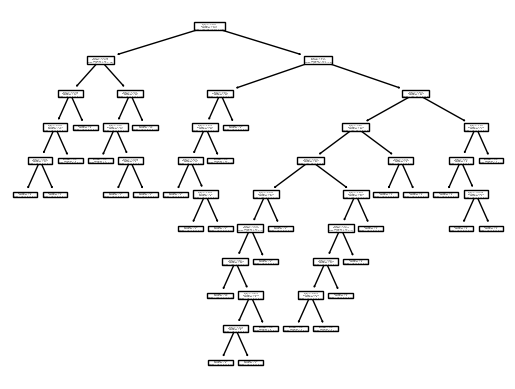

In [153]:
tree_classifier = make_pipeline(imputers["MEAN"], classifiers["DECISION-TREE-10-ENTROPY"])
tree_classifier.fit(X_train, Y_train)
plot_tree(tree_classifier.named_steps["decisiontreeclassifier"])
plt.show()

# Metrics

In [154]:
grid_search = GridSearchCV(search_pipeline, {
    "imputer": list(imputers.values()),
    "transformer": list(transformers.values()),
    "classifier": list(classifiers.values())
}, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print(grid_search.best_score_)
best_pipeline = grid_search.best_estimator_
best_pipeline

0.7983908045977012


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('transformer', QuantileTransformer(n_quantiles=100)),
                ('classifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x18F12483540))])

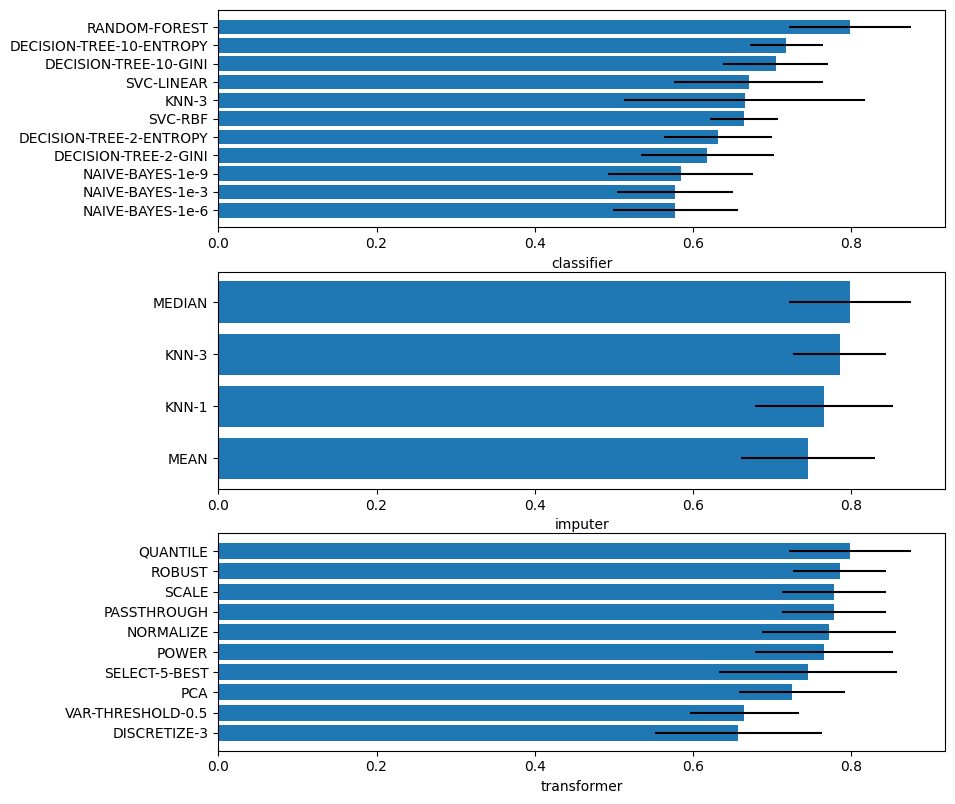

In [155]:
def lookup(what, where):
    match where:
        case "imputer":
            d = imputers
        case "transformer":
            d = transformers
        case "classifier":
            d = classifiers
    return next(k for k in d if d[k] == what)

res = grid_search.cv_results_
fig, ax = plt.subplots(len(grid_search.param_grid), 1, sharex=False, sharey=False, figsize=(8, 8))
fig.tight_layout()
for i, p in enumerate(grid_search.best_params_.keys()):
    x, y, std = zip(*sorted([
        max([
            (lookup(param, p), entry[1], entry[2])
            for entry in zip(res["params"], res["mean_test_score"], res["std_test_score"])
            if entry[0][p] == param
        ], key=lambda x: x[1])
        for param in grid_search.param_grid[p]
    ], key=lambda x: x[1]))

    ax[i].barh(x, y, xerr=std)
    ax[i].set_xlabel(p)

plt.show()

# Final test

In [156]:
final_grid = GridSearchCV(
    make_pipeline(
        SimpleImputer(strategy="median"),
        QuantileTransformer(n_quantiles=100),
        RandomForestClassifier(random_state=rng)
    ),
    {
        "randomforestclassifier__n_estimators": np.arange(50, 500, 10)
    },
    n_jobs=-1
)

final_grid.fit(X_train, Y_train)
print(final_grid.best_score_)
final_estimator = final_grid.best_estimator_
final_estimator

0.7986206896551724


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('quantiletransformer', QuantileTransformer(n_quantiles=100)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=110,
                                        random_state=RandomState(MT19937) at 0x18F1A24D240))])

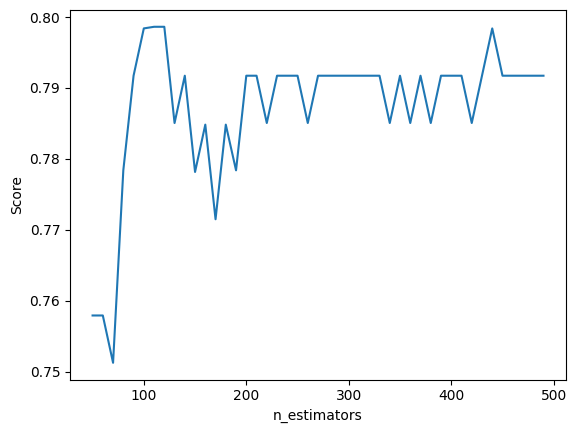

In [157]:
res = final_grid.cv_results_
plt.plot(
    res["param_randomforestclassifier__n_estimators"],
    res["mean_test_score"]
)
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.show()

In [158]:
final_estimator.fit(X_train, Y_train)
predictions = final_estimator.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions, zero_division=0))

0.7692307692307693
[[20  7  0  0  0  0]
 [ 1 20  0  0  0  0]
 [ 6  0  0  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 1  0  0  0  0  5]]
              precision    recall  f1-score   support

           1       0.71      0.74      0.73        27
           2       0.74      0.95      0.83        21
           3       0.00      0.00      0.00         6
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      0.83      0.91         6

    accuracy                           0.77        65
   macro avg       0.74      0.75      0.74        65
weighted avg       0.71      0.77      0.73        65

